## Training and using the model


- On the scientific computing cluster of the University of Leipzig you can use the preinstalled Kernel Python 3.9 TensorFlow 2.6.6 CUDA <br>

- Alternatively: Keep going with Kernel created with environment.yaml and instructions in README.md



Note: Tensorflow provides Information/Warning messages on a red background. These are not error messages. 

<span style='background:yellow'>Import necessary packages</span>

In [1]:
import tensorflow as tf
from tensorflow import  keras 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<span style='background:yellow'>Load preprocessed training and testing data</span>

In [2]:
# Load the arrays from files
INPUT_TRAIN = np.load('input_train_data.npy')
OUTPUT_TRAIN = np.load('output_train_data.npy')

INPUT_TEST = np.load('input_test_data.npy')
OUTPUT_TEST = np.load('output_test_data.npy')

print("Loaded INPUT and OUTPUT files")


Loaded INPUT and OUTPUT files


<span style='background:yellow'>If GPU is available - use GPU</span>

In [3]:
# Check TensorFlow build information
build_info = tf.sysconfig.get_build_info()
print("TensorFlow build information:", build_info)

# List physical GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

if gpus:
    try:
        # Set memory growth to be the same across all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPUs available")

TensorFlow build information: OrderedDict([('cpu_compiler', '/home/conda/feedstock_root/build_artifacts/tensorflow-split_1637954825756/_build_env/bin/x86_64-conda-linux-gnu-gcc'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_62', 'sm_70', 'sm_72', 'sm_75', 'sm_80', 'sm_86', 'compute_86']), ('cuda_version', '11.2'), ('cudnn_version', '8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False)])
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


2024-07-29 11:00:57.868228: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 11:00:58.081132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:05:00.0, compute capability: 7.0


<span style='background:yellow'>Create a layer for the Positional Encoding [@NIPS2017_3f5ee243]:</span>

In [4]:
class PositionalEncoding(keras.layers.Layer):
    """Add a positional encoding."""
    
    def __init__(self):
        super().__init__()
        
    def build(self, input_shape):
        sequence_length = input_shape[-2]
        d_model = input_shape[-1]
        position = np.arange(sequence_length)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = np.zeros((sequence_length, d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.pe = pe

    def call(self, inputs):
        pe_tensor = tf.cast(tf.convert_to_tensor(self.pe), inputs.dtype)

        return inputs + pe_tensor[:tf.shape(inputs)[1], :]

<span style='background:yellow'>Create a Transformer Encoder Block [@NIPS2017_3f5ee243]:</span>

(In this implementation Layer Normalization goes after MultiHeadAttention and after the FeedForward net)

In [5]:
class TransformerEncoderBlock(keras.layers.Layer):
    """Transformer encoder block as Vaswani et al. (2017)."""
    
    def __init__(self,num_heads=7, dff=2048, d_model=1024,return_attention_scores=True): 
        super().__init__()
        
        # Multihead Attention
        self.MHA = keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model)
        self.LN_MHA = keras.layers.LayerNormalization()
        self.dropout = keras.layers.Dropout(0.3)
        self.add_MHA = keras.layers.Add()
        
        # FeedForward
        self.FeedForward = keras.Sequential([
            keras.layers.Dense(dff, activation='relu'),
            keras.layers.Dense(d_model),
            keras.layers.Dropout(0.3)        
        ])
        self.add_FF = keras.layers.Add()
        self.LN_FF = keras.layers.LayerNormalization()
        self.return_attention_scores = return_attention_scores

    def call(self, inputs):
        
        # Multi head attention sublayer
        x, attn = self.MHA(inputs, inputs, return_attention_scores=True)
        x = self.dropout(x)
        x = self.add_MHA([inputs, x])
        x_res = self.LN_MHA(x)

        # Feed Forward sublayer
        x = self.FeedForward(x_res)
        x = self.add_FF([x_res, x])
        x = self.LN_FF(x)
        
        if self.return_attention_scores:
            return x, attn
        else:
            return x

<span style='background:yellow'>Function for creating a Transformer-based model that uses the last output of the sequence:</span>

In [6]:
def LastOutputModel(
    context_window,
    features_length,
    n_transformers = 5, # can be adjusted to improve model performance, though might encounter memory issue when n_transformers is too high 
    num_heads=7,
    dff=2048,
    d_model=1024,
    return_attention_scores=True
):
    
    # Input layer
    inputs = keras.layers.Input(shape=(context_window, features_length))

    # Projection layer
    x = keras.layers.Dense(d_model)(inputs)

    # Positional Encoding
    x = PositionalEncoding()(x)
    
    # Transformer Encoder Block
    for _ in range(n_transformers):
        x, attn = TransformerEncoderBlock(
            num_heads=num_heads,
            dff=dff,
            d_model=d_model,
            return_attention_scores=return_attention_scores
        )(x)

    # Final linear
    outputs = keras.layers.Dense(1,name="primary_output")(x[:, -1, :])
    
    if return_attention_scores:
        outputs = [outputs, attn]

    # Model
    model = keras.models.Model(inputs, outputs=outputs)
    
    return model

<span style='background:yellow'>Create an instance of the model:</span>

In [7]:
# Define these again, due to optional Kernel switch above

CONTEXT_WINDOW= 138  # Length of the input sequences (e.g., time steps)
FEATURES_LENGTH = 6  # Number of features per time step
BATCH_SIZE_TRAIN = 18824  # Adjusted batch size for training (after removing nan coordinates)

BATCH_SIZE_TEST = 714  # Adjusted batch size for testing (after removing nan coordinates)

In [8]:
model = LastOutputModel(CONTEXT_WINDOW,FEATURES_LENGTH)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 138, 6)]          0         
_________________________________________________________________
dense (Dense)                (None, 138, 1024)         7168      
_________________________________________________________________
positional_encoding (Positio (None, 138, 1024)         0         
_________________________________________________________________
transformer_encoder_block (T ((None, 138, 1024), (None 33584128  
_________________________________________________________________
transformer_encoder_block_1  ((None, 138, 1024), (None 33584128  
_________________________________________________________________
transformer_encoder_block_2  ((None, 138, 1024), (None 33584128  
_________________________________________________________________
transformer_encoder_block_3  ((None, 138, 1024), (None 335841

<span style='background:yellow'>**Train the model:**</span>

- spatial split in _TRAIN and _TEST <br>

- earlystop to avoid overfitting the model, training stops if there is no improvement after 5 iterations (patience = 5)

In [9]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss={'primary_output': 'mean_absolute_error'} # mse can be used as well, mae is better when there are outliers
)

# Early stopping callback
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Fit the model
history = model.fit(
    INPUT_TRAIN, 
    OUTPUT_TRAIN, 
    epochs=50,
    # validation_split=0.1,
    validation_data=(INPUT_TEST,OUTPUT_TEST),
    callbacks=earlystop_callback
)

# Save the final model after training:
tf.keras.models.save_model(
    model, 'SIF_transformer_trained', overwrite = True,
    )

2024-07-27 15:42:02.066052: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2024-07-27 15:42:06.077869: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8401


517/517 [==============================] - 250s 477ms/step - loss: 0.4075 - primary_output_loss: 0.4075 - val_loss: 0.2361 - val_primary_output_loss: 0.2361
Epoch 2/50
517/517 [==============================] - 246s 476ms/step - loss: 0.1930 - primary_output_loss: 0.1930 - val_loss: 0.0595 - val_primary_output_loss: 0.0595
Epoch 3/50
517/517 [==============================] - 246s 476ms/step - loss: 0.1252 - primary_output_loss: 0.1252 - val_loss: 0.0429 - val_primary_output_loss: 0.0429
Epoch 4/50
517/517 [==============================] - 246s 476ms/step - loss: 0.0940 - primary_output_loss: 0.0940 - val_loss: 0.0744 - val_primary_output_loss: 0.0744
Epoch 5/50
517/517 [==============================] - 246s 476ms/step - loss: 0.0770 - primary_output_loss: 0.0770 - val_loss: 0.0401 - val_primary_output_loss: 0.0401
Epoch 6/50
517/517 [==============================] - 246s 476ms/step - loss: 0.0631 - primary_output_loss: 0.0631 - val_loss: 0.0228 - val_primary_output_loss: 0.0228
Epo

2024-07-27 16:43:42.617016: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: SIF_transformer_trained_increasedcomplexity/assets


INFO:tensorflow:Assets written to: SIF_transformer_trained_increasedcomplexity/assets
/software/jupyter/conda/envs/tf-gpu/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


<span style='background:yellow'>Save model history as numpy file (to analyse training & validation metrics or review how model's performance evolved during training):</span>

In [ ]:
np.save('SIF_transformer_trained.npy',history.history)

<span style='background:yellow'>Load saved model:</span>
(only necessary if training of the model was not executed within the same session)

In [9]:
model = tf.keras.models.load_model('SIF_transformer_trained')

<span style='background:yellow'>Plot Training and Validation Loss Function:</span>

In [ ]:
# If model was trained within the same session:
# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create array of epoch numbers
epochs = range(1, len(train_loss) + 1)

In [11]:
# If model was trained in previous session, load history file: 
# Load the history
history = np.load('SIF_transformer_trained.npy', allow_pickle=True).item()

# Extract loss values
train_loss = history['loss']
val_loss = history['val_loss']

# Create an array of epoch numbers
epochs = range(1, len(train_loss) + 1)

# Print the values of history file
# print("Training Loss: ", train_loss)
# print("Validation Loss: ", val_loss)
# print("Epochs: ", list(epochs))

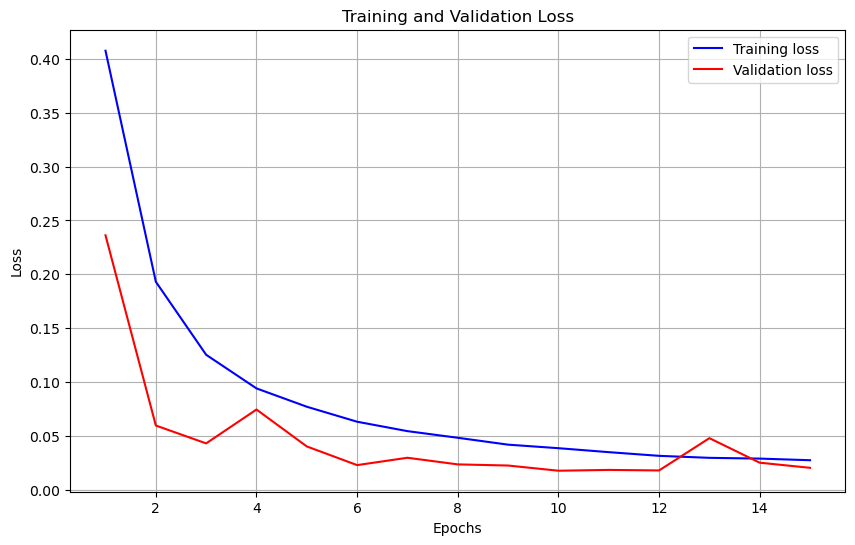

In [12]:
# Plotting loss function 
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


<span style='background:lightblue'> **Interpreting the loss function:** </span>

**Mean absolute error (MAE)**: <br>
- MAE is calculated as the sum of absolute errors divided by the sample size (in other words: average absolute difference between the predicted values and the true values) <br>
- MAE as a loss function is relatively robust to outliers <br>
- To consider: MAE does not penalise large errors as heavily as other loss functions (e.g. root mean squared error) <br>
- Formula:


$$ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right| $$

where $y_i$ is the actual value, $\hat{y}_i$ is the predicted value, and $n$ is the number of samples.

**Training Loss:** <br>
- Training loss consistently decreases with training progress, indicating that the model is learning the the training data <br>
- Smooth curve indicates stable learning <br>

**Validation Loss:** <br>
- Validation loss decreases initially, indicating that the model is generalising well to unseen data <br>
- Around epoch 8 the validation loss plateaus, indicating that the model is beginning to overfit to the training data <br>
- Early stop mechanism stops training process if validation loss hasn't improved within 5 epochs, avoiding overfitting of the model <br>

</span>

<span style='background:yellow'>Optional:</span>
If there ate multiple training runs performance can be compared

In [ ]:
# Optional: If there are multiple training runs, performance ban be compared
# Load history files for comparison
history_data = np.load('history_SIF_transformer_trained.npy', allow_pickle=True).item()
history_data_2 = np.load('history_SIF_transformer_trained2.npy', allow_pickle=True).item()

# Plot both runs
plt.figure(figsize=(12, 6))
plt.plot(history_data['loss'], label='Training Loss Run 1')
plt.plot(history_data_2['loss'], label='Training Loss Run 2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of Training Loss')
plt.legend()
plt.show()


<span style='background:yellow'>Plot attention matrix:</span> <br>
- Average over all heads <br>
- Plot for each head

2024-07-29 11:05:05.240203: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2024-07-29 11:05:06.543512: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8401


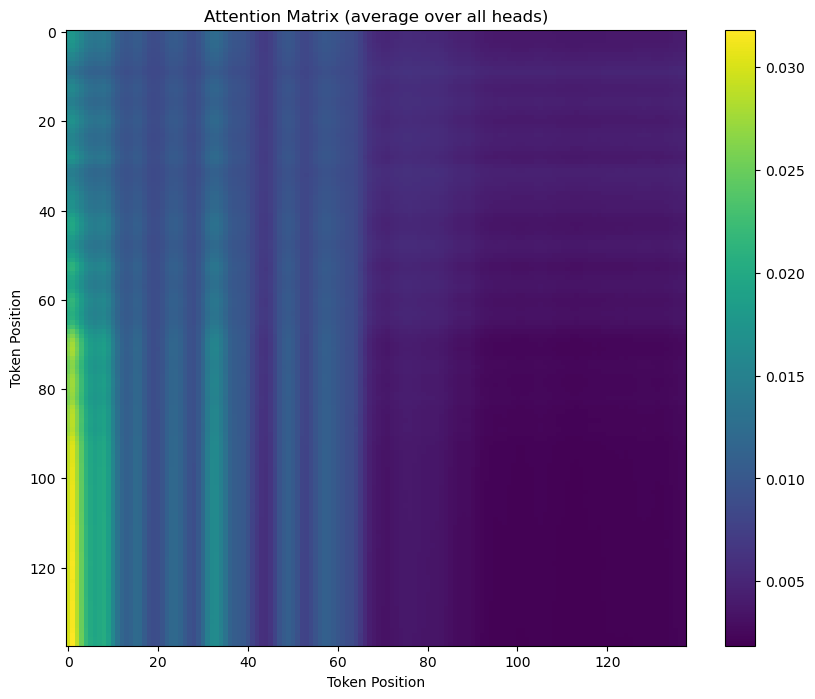

In [13]:
def get_attention_scores(model, input_data):
    outputs, attention_scores = model(input_data, training=False)
    return attention_scores

def combine_attention_heads(attention_scores):
    # Attention scores shape: (batch_size, num_heads, seq_length, seq_length)
    avg_attention_scores = np.mean(attention_scores, axis=1)  # Average over heads
    return avg_attention_scores

def plot_attention_matrix(attention_matrix):
    plt.figure(figsize=(10, 8))
    plt.imshow(attention_matrix, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title('Attention Matrix (average over all heads)')
    plt.xlabel('Token Position')
    plt.ylabel('Token Position')
    plt.show()

# Note: Make sure to use a small batch if dataset is large [INPUT_TRAIN.shape - (16535, 138, 6)]
data_batch = INPUT_TRAIN[:1000]  # Get the first 1000 samples 
# data_batch = INPUT_TRAIN[10000:11000]  # Get samples from 10000 to 11000

attention_scores = get_attention_scores(model, data_batch)
combined_attention = combine_attention_heads(attention_scores)

# Plot matrix for the first example in the batch
plot_attention_matrix(combined_attention[0])

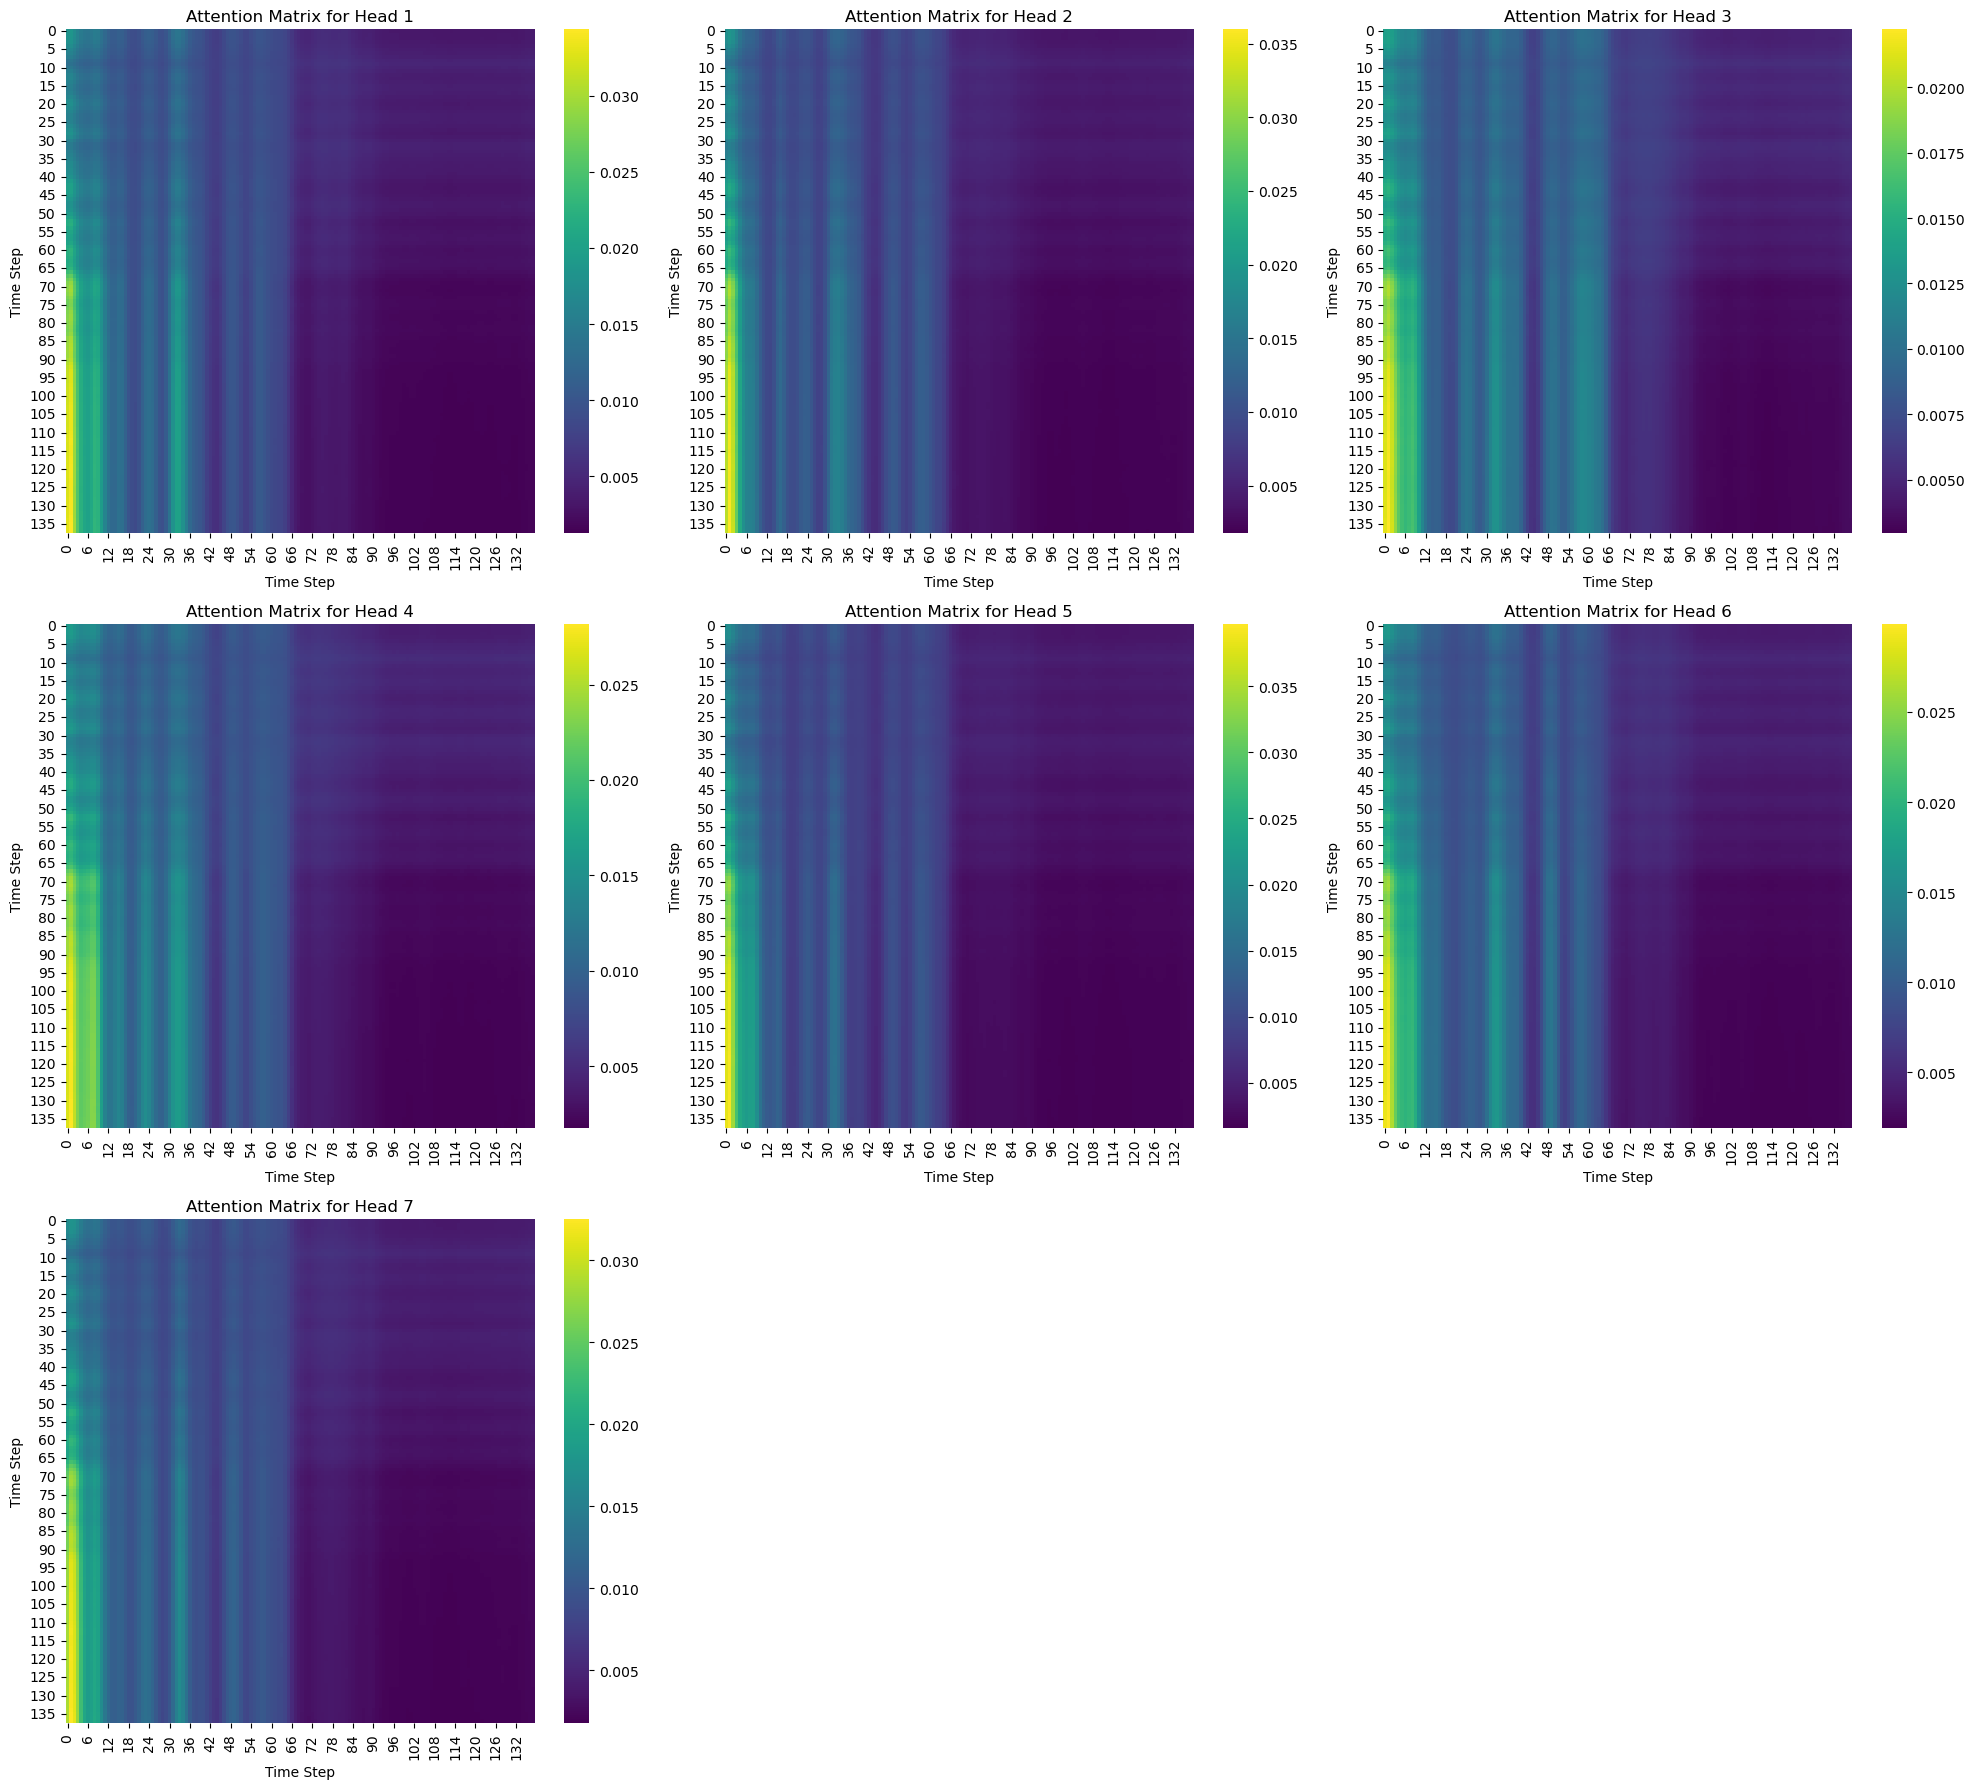

In [14]:
def plot_attention_matrix_for_heads(attention_scores):
    # Extract the single sample from the batch dimension
    attention_scores = attention_scores[0]  # Shape: (6, 138, 138)
    
    num_heads = attention_scores.shape[0]  # Number of attention heads
    seq_len = attention_scores.shape[1]  # Sequence length (time steps)
    
    # Create grid layout for the plots: 3 columns per row
    num_cols = 3
    num_rows = (num_heads + num_cols - 1) // num_cols  # Calculate rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6 * num_rows))
    axes = axes.flatten()  # Flatten the array for easy indexing

    for i in range(num_heads):
        ax = axes[i]
        attention_matrix = attention_scores[i]
        sns.heatmap(attention_matrix, cmap='viridis', cbar=True, annot=False, fmt='.2g', ax=ax
                )
        ax.set_title(f'Attention Matrix for Head {i + 1}')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Time Step')

    # Hide any unused subplots
    for j in range(num_heads, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_attention_matrix_for_heads(attention_scores)


<span style='background:lightblue'> **Interpreting the Attention Matrix:** </span>

**X-Achsis:** Keys, represent positions in input sequence that are being referred to for context - time steps that provide information <br>

**Y-Achsis:** Queries, represent position in input sequence that utilise context from keys - time steps that look for information from other time steps <br>

-> High attention score at position (y, x) indicates that the model is focusing on the information at position x when processing the input at position y <br>

**Vertical yellow stripe indicates higher attention scores**: <br>
- Pattern visible for all 7 attention heads (in slightly varying degrees)  <br>

- Initial time steps (0 to 5) provide crucial context that the model uses to understand the rest of the sequence <br>

- Later time steps (65 to 138) depend significantly on initial context  <br>

**Possible Reasons:** <br>
- Strong dependency of later SIF outcomes to initial environmental conditions  <br>



<span style='background:yellow'>Plot Feature Importance:</span>

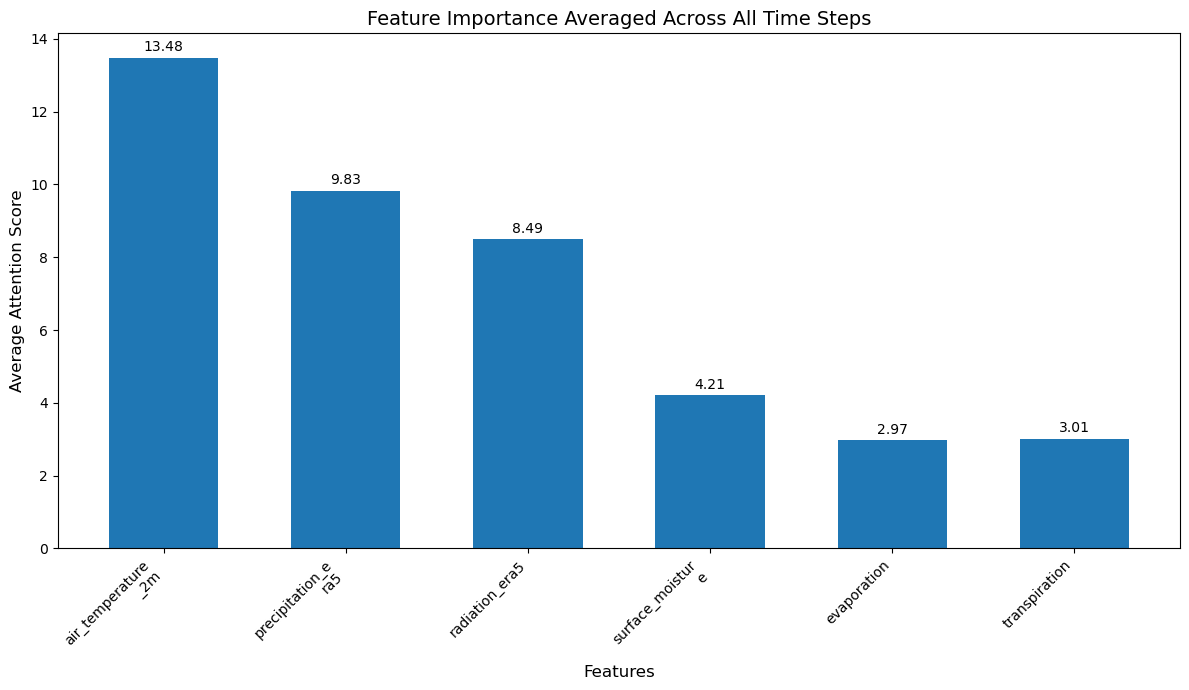

Average importance per feature: [13.479271   9.830906   8.493778   4.210271   2.9745066  3.0112686]


In [15]:
# Function to get attention scores from the model (already defined above)
def get_attention_scores(model, input_data):
    outputs, attention_scores = model(input_data, training=False)
    return attention_scores

# Combine attention heads by summing
def sum_attention_heads(attention_scores):
    summed_attention_scores = np.sum(attention_scores, axis=1)  # Sum over heads (axis 1)
    return summed_attention_scores

# Average the attention scores over all examples in the batch
def average_attention_scores(summed_attention_scores):
    average_importance = np.mean(summed_attention_scores, axis=0)  # Average over batch (axis 0)
    return average_importance

# Calculate feature importance per feature
def calculate_feature_importance(average_importance, features, context_window_length):
    feature_importance_per_feature = np.sum(average_importance, axis=0)  # Sum over time steps (axis 0)
    # Reshape to match the number of features
    average_importance_per_feature = feature_importance_per_feature[:len(features) * (context_window_length // len(features))].reshape(len(features), -1).mean(axis=1)
    return average_importance_per_feature

# Plot the feature importance
def plot_feature_importance(features, average_importance_per_feature):
    plt.figure(figsize=(12, 7))  # Increase figure size for better readability
    bars = plt.bar(features, average_importance_per_feature, width=0.6)  # Increase width for spacing

    # Rotate x-axis labels and reduce font size
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Average Attention Score', fontsize=12)
    plt.title('Feature Importance Averaged Across All Time Steps', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels and align them to the right

    # Manually wrap long labels
    wrapped_labels = [label if len(label) < 15 else '\n'.join([label[i:i+15] for i in range(0, len(label), 15)]) for label in features]
    plt.gca().set_xticks(range(len(features)))  # Set ticks manually
    plt.gca().set_xticklabels(wrapped_labels)  # Set wrapped labels

    # Add value labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()  
    plt.show()

sample_indices = range(10000, 11000)  # Adjust as needed
# sample_indices = range(15000,16000) 
# sample_indices = range(0,1000) 

# Extract data batches for the selected samples
data_batches = INPUT_TRAIN[sample_indices, :, :]  # Select the entire sequence for the samples

# Get attention scores
attention_scores = get_attention_scores(model, data_batches)

# Sum attention scores over all heads
summed_attention_scores = sum_attention_heads(attention_scores)

# Average scores over all examples in the batch
average_importance = average_attention_scores(summed_attention_scores)

# Define features (see 'variables' in preprocessing) and context window length
features = ['air_temperature_2m', 'precipitation_era5', 'radiation_era5', 'surface_moisture' ,'evaporation', 'transpiration']
context_window_length = INPUT_TRAIN.shape[1] # INPUT_TRAIN.shape: [samples, conetxt window (time steps), features]

# Calculate feature importance per feature
average_importance_per_feature = calculate_feature_importance(average_importance, features, context_window_length)

# Plot the feature importance
plot_feature_importance(features, average_importance_per_feature)

print(f'Average importance per feature: {average_importance_per_feature}')


<span style='background:lightblue'> **Interpreting the Feature Importance:** </span> <br>

- Air temperature has the highest importance score, indicating that air temp is the most influential variable in our model <br>

- Precipitation, closely followed by radiation also have significant impact on SIF prediction in our model <br>

- Moderate importance of surface moisture <br>

- Low importance of evaporation and transpiration <br>

-> Aligns with understanding, that temperature, precipitation and light (radiation) directly impact plant photosynthetic activity <br>

Note: When tested with other sample_indices the feature importance values differ slightly, but the hierachy of feature importance stays the same <br>



<span style='background:yellow'>Simulate models prediction of SIF on conditions of July 2018 drought in Germany:</span> <br>

(Note: See Preprocessing for calculation of mean, normalised feature values of July 2018 in Germany)

In [16]:
import numpy as np
import pandas as pd

# Define the features list
features = ['air_temperature_2m', 'precipitation_era5', 'radiation_era5', 'surface_moisture', 'evaporation', 'transpiration']

# Function to get predictions from the model
def get_predictions(model, input_data):
    predictions, _ = model.predict(input_data)
    return predictions

# Select a batch of test inputs (e.g., the first batch)
sample_input = INPUT_TEST[:BATCH_SIZE_TEST]

# Get the original predictions
original_predictions = get_predictions(model, sample_input)

# Mean values for July 2018
mean_values_july_2018 = {
    'air_temperature_2m': 0.8101357677984857,
    'precipitation_era5': 0.09217376515411849,
    'radiation_era5': 0.686266861634277,
    'surface_moisture': 0.40022046308959586,
    'evaporation': 0.43960238037652755,
    'transpiration': 0.661117381373725,
    'sif_gosif': 0.47830269266898034
}

# Create a new input array with the mean values for July 2018
absolute_input = np.zeros_like(sample_input)
for i, feature in enumerate(features):
    absolute_input[:, :, i] = mean_values_july_2018[feature]

# Get predictions for the absolute input
absolute_predictions = get_predictions(model, absolute_input)

# Calculate the mean of the original predictions
mean_original_predictions = np.mean(original_predictions)

# Calculate the mean values for the original input data
mean_original_values = {feature: np.mean(sample_input[:, :, i]) for i, feature in enumerate(features)}

# Add the mean predicted SIF to the mean values
mean_original_values['sif_gosif'] = mean_original_predictions

# Prepare the absolute values dictionary
mean_absolute_values = mean_values_july_2018.copy()
mean_absolute_values['sif_gosif'] = np.mean(absolute_predictions)

# Create a DataFrame to display the results
data = {
    'Feature': list(mean_original_values.keys()),
    'Original Prediction Mean': list(mean_original_values.values()),
    'July 2018 in Germany Mean': list(mean_absolute_values.values())
}

df = pd.DataFrame(data)

# Display the DataFrame
df


,Feature,Original Prediction Mean,July 2018 in Germany Mean
0,air_temperature_2m,0.593878,0.810136
1,precipitation_era5,0.046978,0.092174
2,radiation_era5,0.475065,0.686267
3,surface_moisture,0.421133,0.400220
4,evaporation,0.231656,0.439602
5,transpiration,0.362578,0.661117
6,sif_gosif,0.111083,0.287867


<span style='background:lightblue'> **Interpretation of SIF prediction for values of July 2018 in Germany:** </span> <br>

- SIF increased in comparison to original prediction <br>

- Increased temperature, precipitation and radation are in favor of photosynthetic activity <br>

-> Aligns with understanding, that temperature, precipitation and light (radiation) directly impact plant photosynthetic activity 

<span style='background:yellow'>Simulate models prediction of SIF on drought scenario (only air temp and precipitation altered):</span>

In [17]:
# Select a batch of test inputs (e.g., the first batch)
sample_input = INPUT_TEST[:BATCH_SIZE_TEST]

# Get the original predictions
original_predictions = get_predictions(model, sample_input)

# Mean values for Drought Scenario (increased air_temp, decreased precipitation in comparison to Original Prediction Mean for each feature)
mean_values_drought = {
    'air_temperature_2m': 0.8,
    'precipitation_era5': 0.01,
    'radiation_era5': 0.475065,
    'surface_moisture': 0.421133,
    'evaporation': 0.231656,
    'transpiration': 0.362578,
    'sif_gosif': 0.111083
}

# Create a new input array with the mean values for July 2018
drought_input = np.zeros_like(sample_input)
for i, feature in enumerate(features):
    drought_input[:, :, i] = mean_values_drought[feature]

# Get predictions for the July 2018 input
drought_predictions = get_predictions(model, drought_input)

# Calculate the mean of the original predictions
mean_original_predictions = np.mean(original_predictions)

# Calculate the mean values for the original input data
mean_original_values = {feature: np.mean(sample_input[:, :, i]) for i, feature in enumerate(features)}

# Add the mean predicted SIF to the mean values
mean_original_values['sif_gosif'] = mean_original_predictions

# Prepare the July 2018 values dictionary
mean_values_drought = mean_values_drought.copy()
mean_values_drought['sif_gosif'] = np.mean(drought_predictions)

# Create a DataFrame to display the results
data = {
    'Feature': list(mean_original_values.keys()),
    'Original Prediction Mean': list(mean_original_values.values()),
    'Drought Scenario': list(mean_values_drought.values())
}

df = pd.DataFrame(data)

# Display the DataFrame
df


,Feature,Original Prediction Mean,Drought Scenario
0,air_temperature_2m,0.593878,0.800000
1,precipitation_era5,0.046978,0.010000
2,radiation_era5,0.475065,0.475065
3,surface_moisture,0.421133,0.421133
4,evaporation,0.231656,0.231656
5,transpiration,0.362578,0.362578
6,sif_gosif,0.111083,0.127126


<span style='background:lightblue'> **Interpretation of SIF prediction for Drought Scenario:** </span> <br>

- SIF increased in comparison to original prediction <br>

- Increase in air temperature, decrease in precipitation <br>

-> Does **not** align with understanding that water availability limits plant photosynthetic activity

<span style='background:yellow'>Simulate SIFs reaction to individual features being increased/decreased:</span>

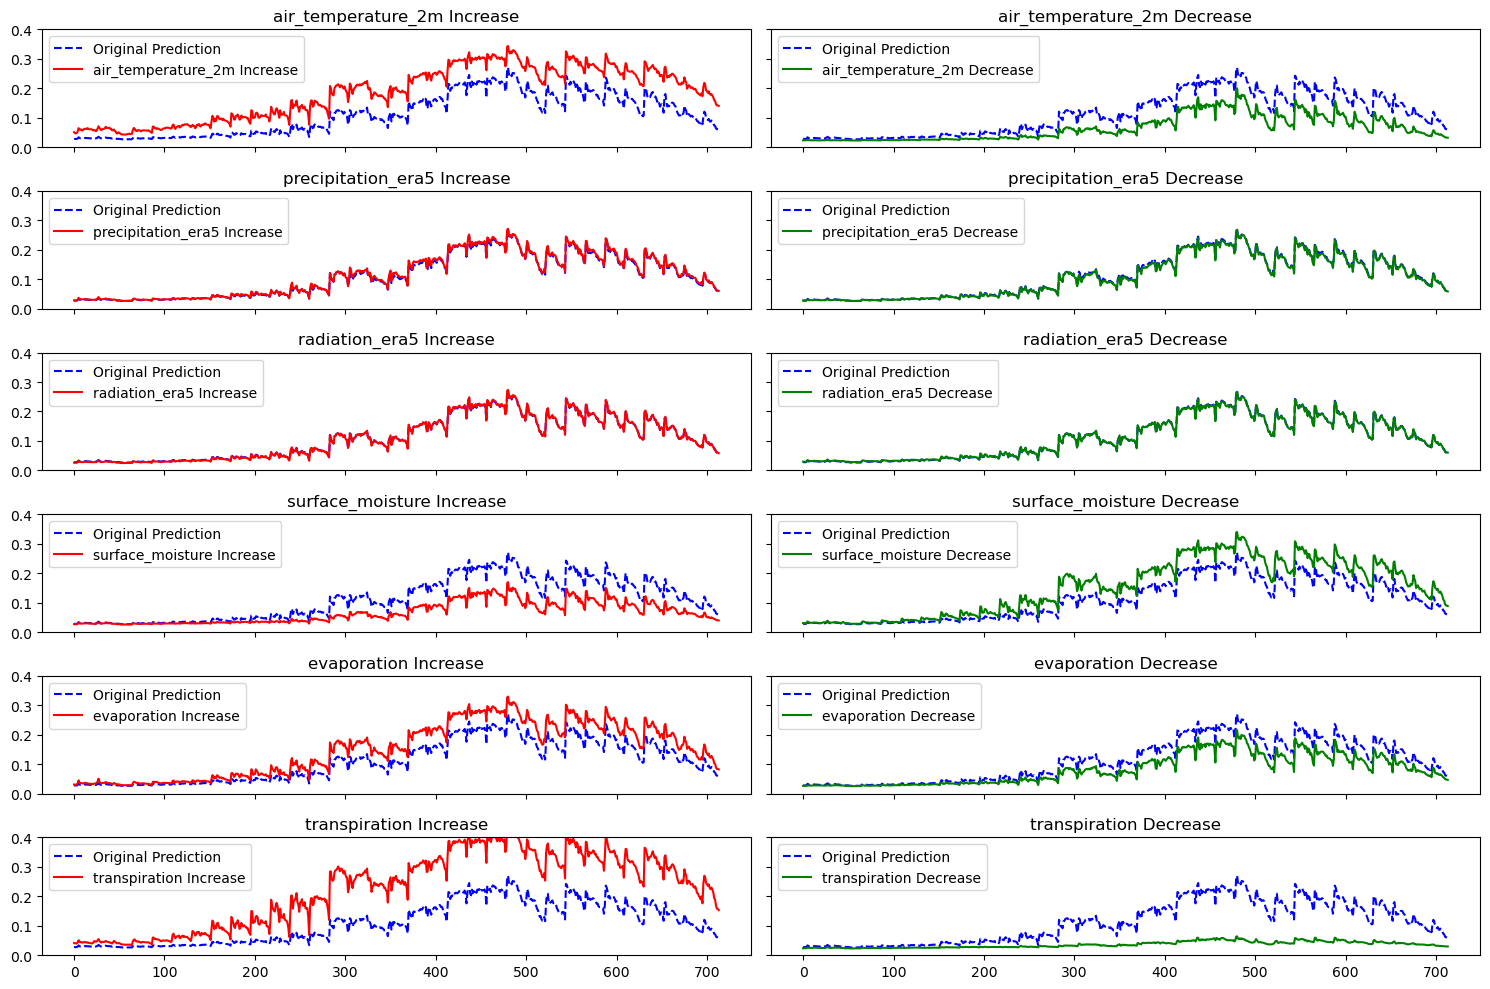

In [18]:
# Define the features list
features = ['air_temperature_2m', 'precipitation_era5', 'radiation_era5', 'surface_moisture', 'evaporation', 'transpiration']

# Define individual feature scenarios
individual_feature_scenarios = {
    f'{feature} Increase': {feature: 1.5} for feature in features
}
individual_feature_scenarios.update({
    f'{feature} Decrease': {feature: 0.5} for feature in features
})

# Function to get predictions from the model
def get_predictions(model, input_data):
    predictions, _ = model.predict(input_data)
    return predictions

# Select a batch of test inputs (e.g., the first batch)
sample_input = INPUT_TEST[:BATCH_SIZE_TEST]

# Get the original predictions
original_predictions = get_predictions(model, sample_input)

# Plotting setup
num_features = len(features)
cols = 2  # Increase and decrease scenarios side by side
rows = num_features

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Plot original predictions once for reference
for ax in axes:
    ax.plot(original_predictions, label='Original Prediction', linestyle='--', color='blue')

# Simulate changes for each individual feature scenario
i = 0
for feature in features:
    # Increase scenario
    increase_scenario = {feature: 2}
    increase_input = np.copy(sample_input)
    index = features.index(feature)
    increase_input[:, :, index] *= increase_scenario[feature]
    increase_predictions = get_predictions(model, increase_input)
    
    # Decrease scenario
    decrease_scenario = {feature: 0.25}
    decrease_input = np.copy(sample_input)
    decrease_input[:, :, index] *= decrease_scenario[feature]
    decrease_predictions = get_predictions(model, decrease_input)
    
    # Plot the comparisons
    axes[i].plot(increase_predictions, label=f'{feature} Increase', linestyle='-', color='red')
    axes[i].set_title(f'{feature} Increase')
    axes[i].legend()
    axes[i].set_ylim(0, 0.4)  # Set y-axis limits
    
    axes[i+1].plot(decrease_predictions, label=f'{feature} Decrease', linestyle='-', color='green')
    axes[i+1].set_title(f'{feature} Decrease')
    axes[i+1].legend()
    axes[i+1].set_ylim(0, 0.4)  # Set y-axis limits
    
    i += 2  # Move to the next pair of plots

# Adjust layout
plt.tight_layout()
plt.show()

<span style='background:lightblue'> **Interpretation of SIF prediction for individual features being increased/decreased:** </span>

**Air temperature:** <br>

- SIF prediction increases with increased temperature, and decreases with decreased temperature <br>

- Aligns with understanding that initially increasing temperature (up to a limit of 45°C) increases rate of photosynthesis <br>

**Precipitation:** <br>

- Increasing / Decreasing Precipitation does not have much effect on prediction of SIF <br>

- Considerations: Doubling precipitation (original mean value: 0.046978) might not have as big of an effect as doubling air temperature (original mean value: 0.593878) as original value is much bigger to begin with <br>

- The model might not have learned the relationship between precipitation and the target variable effectively <br>

- The effect of precipitation might be significant only when combined with changes in other features <br>

**Radiation:** 
<br>
- Increasing / Decreasing Precipitation does not have much effect on prediction of SIF <br>

**Surface Moisture:** <br>

- Increasing surface moisture results in lower SIF values in prediction <br>

- Decreasing surface moisture results in higher SIF values in prediction  <br>

- Does **not** align with understanding that water availability limits photosynthetic activity <br>

- The model might not have learned the relationship between surface moisture and the target variable effectively <br>

**Evaporation:** <br>

- Increasing evaporation results in higher SIF values in prediction <br>

- Decreasing evaporation results in lower SIF values in prediction <br>

- Higher evaporation can lead to water stress  and thus limit photosynthetic activity BUT if enough water is available higher evaporation can be an indicator of higher temperatures, leading to more photosynthetic activity <br>

- As feature attention on evaporation is low: The model might have learned the effect of evaporation in combination with changes in other features

**Transpiration:** <br>

- Increasing transpiration results in higher SIF values in prediction <br>

- Decreasing transpiration results in lower SIF values in prediction <br>

- Aligns with understanding that higher transpiration (process of water movement through a plant) increases water availability for photosynthetic activity <br>

- As feature attention on transpiration is low: The model might have learned the effect of transpiration in combination with changes in other features <br> 

<span style='background:yellow'>Simulation of SIF Predictions Under Drought, Intense Rainfall, and Heatwave Scenarios:</span>

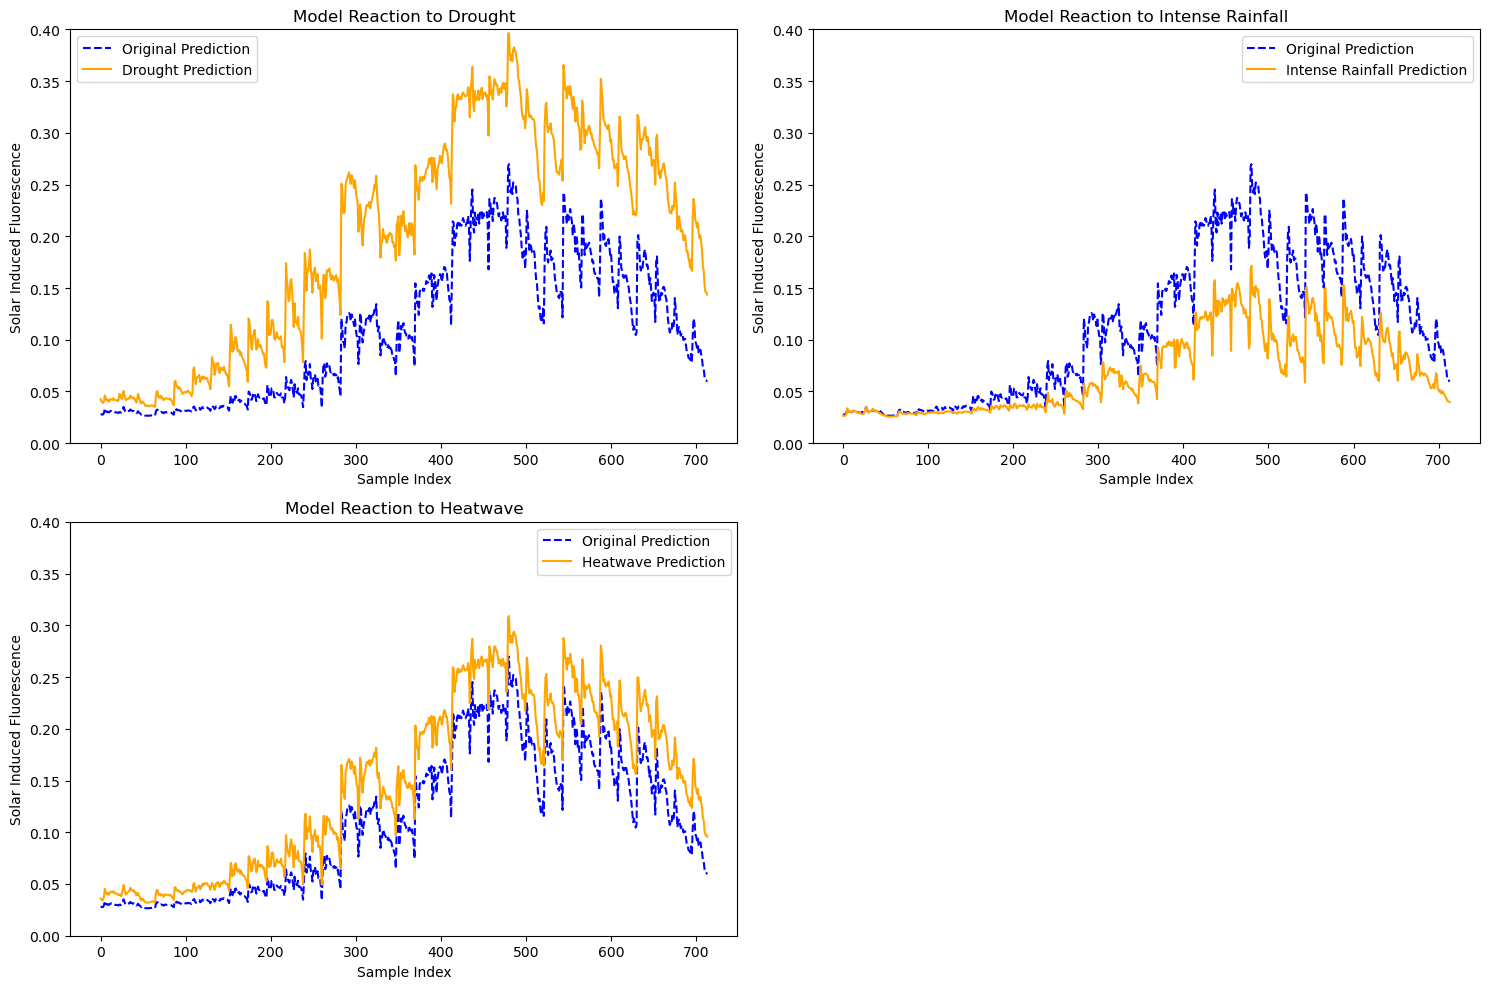

In [19]:
# Define scenarios
scenarios = {
    'Drought': {
        'air_temperature_2m': 1.5, # Increase temperature by 50%
        'precipitation_era5': 0.2, # Decrease precipitation by 80%
        'surface_moisture': 0.01 # Decrease soil moisture to very low
    },
    'Intense Rainfall': {
        'precipitation_era5': 2, # Increase precip by 100%
        'surface_moisture': 2 # Increase soil moisture by 100%
    },
    'Heatwave': {
        'air_temperature_2m': 1.5, # Increase air temp by 50%
        'radiation_era5': 1.2       # Increase radiation by 20%
    },
}

# Define the features list
features = ['air_temperature_2m', 'precipitation_era5', 'radiation_era5', 'surface_moisture', 'evaporation', 'transpiration']

# Function to get predictions from the model
def get_predictions(model, input_data):
    predictions, _ = model.predict(input_data)
    return predictions

# Select a batch of test inputs (e.g., the first batch)
sample_input = INPUT_TEST[:BATCH_SIZE_TEST]

# Get the original predictions
original_predictions = get_predictions(model, sample_input)

# Set up the plotting grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Simulate extreme events and plot predictions
for i, (scenario, changes) in enumerate(scenarios.items()):
    scenario_input = np.copy(sample_input)
    
    # Apply changes based on the scenario
    for feature, factor in changes.items():
        index = features.index(feature)
        scenario_input[:, :, index] *= factor
        if factor == 0.01:
            scenario_input[:, :, index] = 0.01
    
    # Predict using the modified input
    scenario_predictions = get_predictions(model, scenario_input)
    
    # Plot the comparison for each scenario
    ax = axes[i]
    ax.plot(original_predictions, label='Original Prediction', linestyle='--', color='blue')
    ax.plot(scenario_predictions, label=f'{scenario} Prediction', linestyle='-', color='orange')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Solar Induced Fluorescence')
    ax.set_title(f'Model Reaction to {scenario}')
    ax.legend()
    ax.set_ylim(0, 0.4)  # Set y-axis limits

# Hide the fourth subplot if there are only three scenarios
if len(scenarios) < 4:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


<span style='background:lightblue'> **Interpretation of SIF prediction for Drought, Intense Rainfall, and Heatwave Scenarios:** </span>

**Drought:** <br>

- SIF prediction increases  <br>

- Does **not** align with understanding that water availability limits photosynthetic activity <br>

- The model might not capture the interaction of precipitation, air temperature and surface_moisture in relation to SIF correctly <br>

**Intense Rainfall:** <br>

- SIF prediction decreases <br>

- Does **not** align with understanding that higher water availability leads to photosynthetic activity <br>

**Heatwave:** <br>

- SIF prediction increases <br>

- Increase of temperature might lead to higher photosynthetic activity as long as enough water available - aligns with expectation <br>
